# Library Imports

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.random_projection import GaussianRandomProjection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from random import sample
from collections import Counter
from typing import List, Dict, Union

# Parsing and Cleaning Data

In [2]:
file_name = "SpotifyFeatures.csv"
spotify_data = pd.read_csv(file_name)
spotify_data.dropna()
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [3]:
def get_counter_from_column(dataframe: pd.DataFrame, column: str) -> Counter:
    unique = Counter(dataframe[column])
    return unique

# getting an idea of what non-numerical values we might have for data so we can map them to numbers later
# excluding things such as artist_name, track_name, and track_id due to the sheer size and number of unique elements
column_names = ["genre", "key", "mode", "time_signature"]
unique_genres, unique_keys, unique_modes, unique_time_signatures = [get_counter_from_column(spotify_data, column) for column in column_names]

print(f"Unique values for genre: {unique_genres}")
print(f"Unique values for key: {unique_keys}")
print(f"Unique values for mode: {unique_modes}")
print(f"Unique values for time signature: {unique_time_signatures}")

Unique values for genre: Counter({'Comedy': 9681, 'Soundtrack': 9646, 'Indie': 9543, 'Jazz': 9441, 'Pop': 9386, 'Electronic': 9377, 'Children’s Music': 9353, 'Folk': 9299, 'Hip-Hop': 9295, 'Rock': 9272, 'Alternative': 9263, 'Classical': 9256, 'Rap': 9232, 'World': 9096, 'Soul': 9089, 'Blues': 9023, 'R&B': 8992, 'Anime': 8936, 'Reggaeton': 8927, 'Ska': 8874, 'Reggae': 8771, 'Dance': 8701, 'Country': 8664, 'Opera': 8280, 'Movie': 7806, "Children's Music": 5403, 'A Capella': 119})
Unique values for key: Counter({'C': 27583, 'G': 26390, 'D': 24077, 'C#': 23201, 'A': 22671, 'F': 20279, 'B': 17661, 'E': 17390, 'A#': 15526, 'F#': 15222, 'G#': 15159, 'D#': 7566})
Unique values for mode: Counter({'Major': 151744, 'Minor': 80981})
Unique values for time signature: Counter({'4/4': 200760, '3/4': 24111, '5/4': 5238, '1/4': 2608, '0/4': 8})


In [4]:
def remove_data_with_values(dataframe: pd.DataFrame, column_name: str, values: List[str]) -> pd.DataFrame:
    criteria = lambda row: row[column_name] not in values
    return dataframe[dataframe.apply(criteria, axis=1)]

def create_integer_mapping(items: List[str]) -> Dict[str, int]:
    return {item: i for i, item in enumerate(items)}

def replace_values(dataframe: pd.DataFrame, values_to_merge: List[str], new_value: str) -> pd.DataFrame:
    return dataframe.copy().replace(to_replace=values_to_merge, value=new_value)

# remove rows that have a 0/4 time signature 
time_signatures_to_remove = ["0/4"]
spotify_data_removed = remove_data_with_values(spotify_data, "time_signature", time_signatures_to_remove)

# remove rows that have the genre of acapella, children's music, comedy
genres_to_remove = ["A Capella", "Children's Music", 'Children’s Music', "Comedy"]
spotify_data_removed = remove_data_with_values(spotify_data_removed, "genre", genres_to_remove)

# merge rap and hip-hop genres
spotify_data_merged = replace_values(spotify_data_removed, ["Rap", "Hip-Hop"], "Rap/Hip-Hop")
# merge movie and soundtrack genres
spotify_data_merged = replace_values(spotify_data_merged, ["Movie", "Soundtrack"], "Movie/Soundtrack")
# merge reggae and reggaeton genres
spotify_data_merged = replace_values(spotify_data_merged, ["Reggae", "Reggaeton"], "Reggae/Reggaeton")

unique_genres, unique_keys, unique_modes, unique_time_signatures = [get_counter_from_column(spotify_data_merged, column) for column in column_names]

genre_integer_mapping = create_integer_mapping(list(unique_genres))
key_integer_mapping = create_integer_mapping(list(unique_keys))
mode_integer_mapping = create_integer_mapping(list(unique_modes))
time_signature_mapping = create_integer_mapping(list(unique_time_signatures))

print(f"Genre to integer mapping: {genre_integer_mapping}")
print(f"Key to integer mapping: {key_integer_mapping}")
print(f"Mode to integer mapping: {mode_integer_mapping}")
print(f"Time signature to integer mapping: {time_signature_mapping}")

Genre to integer mapping: {'Movie/Soundtrack': 0, 'R&B': 1, 'Alternative': 2, 'Country': 3, 'Dance': 4, 'Electronic': 5, 'Anime': 6, 'Folk': 7, 'Blues': 8, 'Opera': 9, 'Rap/Hip-Hop': 10, 'Indie': 11, 'Classical': 12, 'Pop': 13, 'Reggae/Reggaeton': 14, 'Jazz': 15, 'Rock': 16, 'Ska': 17, 'Soul': 18, 'World': 19}
Key to integer mapping: {'C#': 0, 'F#': 1, 'C': 2, 'F': 3, 'G': 4, 'E': 5, 'D#': 6, 'G#': 7, 'D': 8, 'A#': 9, 'A': 10, 'B': 11}
Mode to integer mapping: {'Major': 0, 'Minor': 1}
Time signature to integer mapping: {'4/4': 0, '5/4': 1, '3/4': 2, '1/4': 3}


In [5]:
# replace values based on a list of dictionary mappings
def replace_mappings(dataframe: pd.DataFrame, mappings: List[Dict[str, int]]) -> pd.DataFrame:
    merged_mapping = {}
    new_dataframe = dataframe.copy()
    for mapping in mappings:
        merged_mapping.update(mapping)
    new_dataframe = new_dataframe.replace(to_replace=merged_mapping)
    return new_dataframe

# use the mappings from the previous cell and show that the only rows with a non-integer/float datatype are artist_name, track_name, and track_id
spotify_data_replaced = replace_mappings(spotify_data_merged, [genre_integer_mapping, key_integer_mapping, mode_integer_mapping, time_signature_mapping])
spotify_data_replaced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208162 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             208162 non-null  int64  
 1   artist_name       208162 non-null  object 
 2   track_name        208162 non-null  object 
 3   track_id          208162 non-null  object 
 4   popularity        208162 non-null  int64  
 5   acousticness      208162 non-null  float64
 6   danceability      208162 non-null  float64
 7   duration_ms       208162 non-null  int64  
 8   energy            208162 non-null  float64
 9   instrumentalness  208162 non-null  float64
 10  key               208162 non-null  int64  
 11  liveness          208162 non-null  float64
 12  loudness          208162 non-null  float64
 13  mode              208162 non-null  int64  
 14  speechiness       208162 non-null  float64
 15  tempo             208162 non-null  float64
 16  time_signature    20

In [6]:
# drop a given list of column names from a dataframe
def drop_columns(dataframe: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    new_dataframe = dataframe.copy()
    for column in columns:
        new_dataframe = new_dataframe.drop(column, 1)
    return new_dataframe

def print_random_rows(array: Union[np.ndarray, pd.Series], num: int) -> None:
    indexes = sample(range(len(array)), num)
    for index in indexes:
        item = array[index]
        print(f"\tindex {index}: {item}, {item.size} feature(s)")

random_samples = 3

# create our array of target variables
Y = spotify_data_replaced["genre"]
print(f"{random_samples} random samples from Y, {len(Y)} samples total:")
print_random_rows(Y, random_samples)

# drop genres, artist names, track names, and track ids from dataframe
spotify_data_dropped = drop_columns(spotify_data_replaced, ["genre", "artist_name", "track_name", "track_id"])

# create our array of samples and variables
X = spotify_data_dropped.to_numpy()
print(f"{random_samples} random samples from X, {len(X)} samples total:")
print_random_rows(X, random_samples)

3 random samples from Y, 208162 samples total:
	index 115640: 10, 1 feature(s)
	index 16884: 4, 1 feature(s)
	index 22568: 5, 1 feature(s)
3 random samples from X, 208162 samples total:
	index 85571: [ 6.30000e+01  3.22000e-01  6.47000e-01  2.15676e+05  6.50000e-01
  0.00000e+00  3.00000e+00  3.40000e-01 -3.84800e+00  1.00000e+00
  4.49000e-02  7.40000e+01  0.00000e+00  6.77000e-01], 14 feature(s)
	index 64684: [ 4.30000e+01  9.56000e-01  4.71000e-01  1.52520e+05  1.76000e-01
  1.21000e-05  8.00000e+00  9.10000e-02 -1.18120e+01  0.00000e+00
  5.07000e-02  1.06039e+02  0.00000e+00  1.80000e-01], 14 feature(s)
	index 185933: [ 4.60000e+01  6.83000e-04  3.13000e-01  4.65387e+05  6.50000e-01
  0.00000e+00  8.00000e+00  1.54000e-01 -6.33500e+00  0.00000e+00
  3.22000e-02  1.42029e+02  0.00000e+00  1.12000e-01], 14 feature(s)


# Visualizing Data

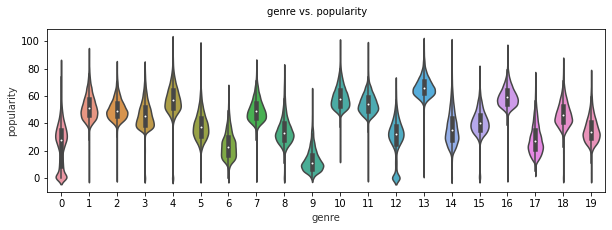

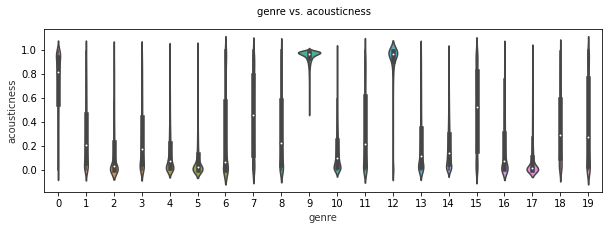

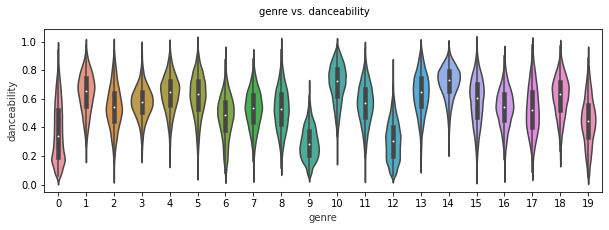

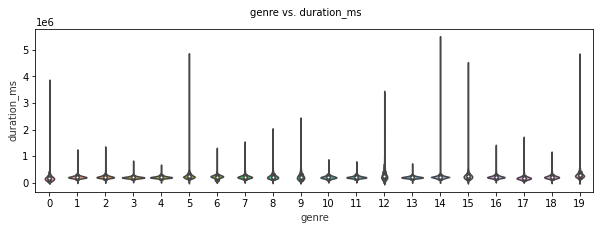

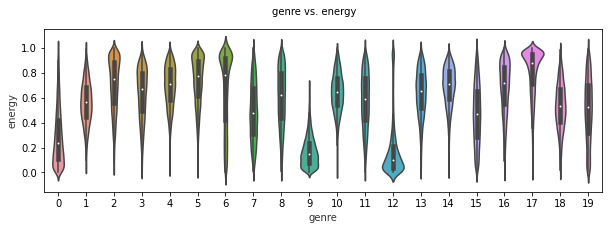

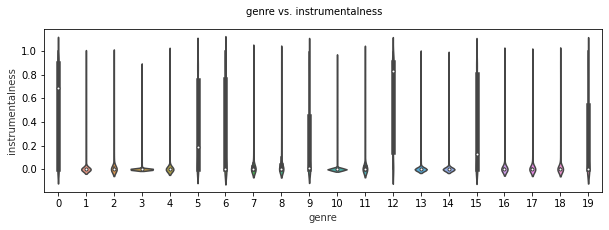

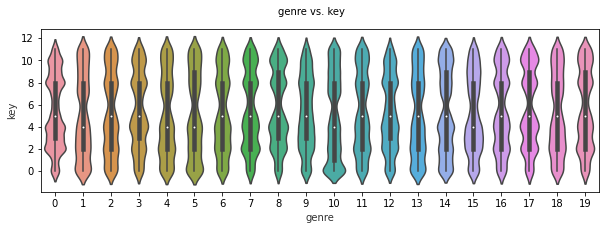

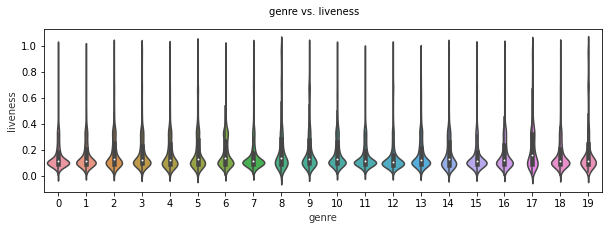

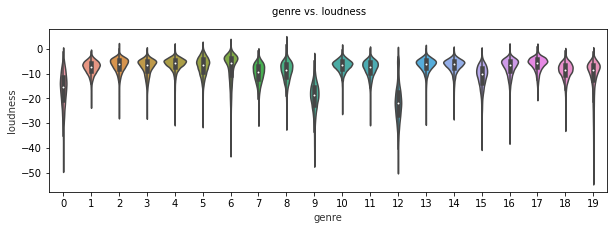

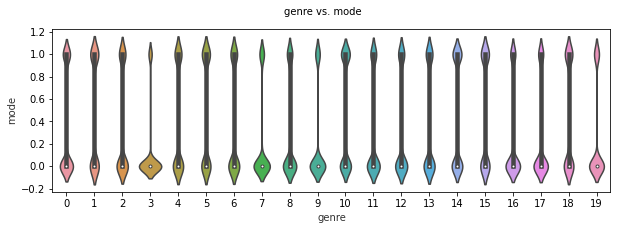

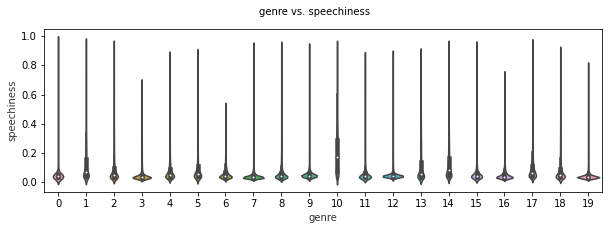

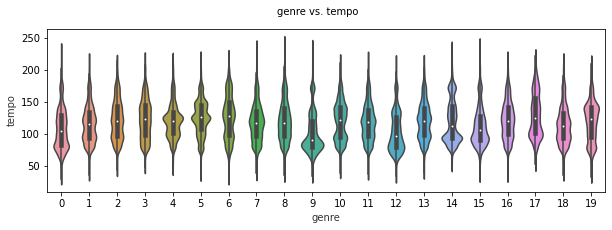

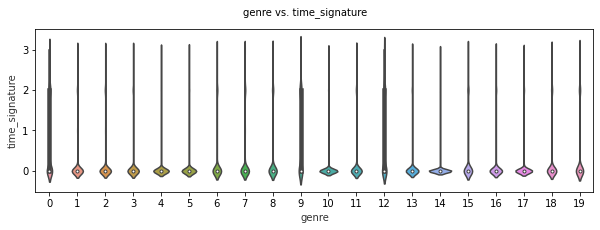

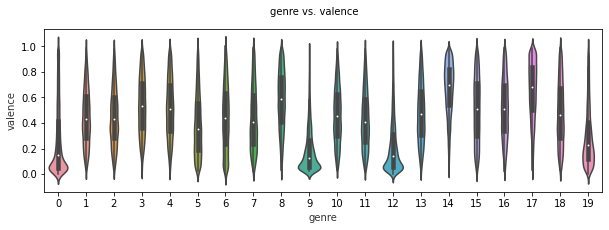

In [7]:
def violin_plot(x: str, y: str, data: pd.DataFrame):
    f, (ax) = plot.subplots(1, 1, figsize = (10, 3))
    f.suptitle(f"{x} vs. {y}", fontsize = 10)

    sns.violinplot(x=x, y=y, data=data, ax=ax)
    ax.set_xlabel(x, size = 10, alpha = 0.8)
    ax.set_ylabel(y, size = 10, alpha = 0.8)

    plot.savefig(f"data_vis/{x}_vs_{y}.png")

attributes = ["popularity", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature", "valence"]
for attribute in attributes:
    violin_plot("genre", attribute, spotify_data_replaced)

# Training Our SVM

In [8]:
# standardizing our data using a scaler
scaler = StandardScaler()
# scale our data
X_scaled = scaler.fit_transform(X)

In [9]:
# split our data into testing and training splits
test_ratio = 0.25

X_sampled, Y_sampled = resample(X_scaled, Y, n_samples=100000, random_state=21)

X_train, X_test, Y_train, Y_test = train_test_split(X_sampled, Y_sampled, test_size=test_ratio, random_state=21)
print(f"Size of training set: {len(X_train)} / {len(X_sampled)} = {100 * len(X_train) / len(X_sampled):0.2f}%")
print(f"Size of testing set: {len(X_test)} / {len(X_sampled)} = {100 * len(X_test) / len(X_sampled):0.2f}%")

Size of training set: 75000 / 100000 = 75.00%
Size of testing set: 25000 / 100000 = 25.00%


In [10]:
model = KNeighborsClassifier(weights="distance")
model.fit(X_train, Y_train)

KNeighborsClassifier(weights='distance')

In [11]:
score = model.score(X_test, Y_test)

In [12]:
print(score)

0.52004
